In [2]:
import tarfile 
import os
import pandas as pd
import urllib
import numpy as np
import joblib
from scipy.stats import expon, reciprocal
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV


## Get data

In [3]:
download_root = "https://raw.githubusercontent.com/mlbvn/handson-ml2-vn/main/"
housing_path = os.path.join("datasets", "housing")
housing_url = download_root + "datasets/housing/housing.tgz"
print(housing_url)

https://raw.githubusercontent.com/mlbvn/handson-ml2-vn/main/datasets/housing/housing.tgz


In [4]:
def get_housing_data(housing_url = housing_url,housing_path = housing_path):
    os.makedirs(housing_path,exist_ok= True) # Tao duong dan thu muc
    tgz_path = os.path.join(housing_path,"housing.tgz") #file
    urllib.request.urlretrieve(housing_url,tgz_path) 
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path = housing_path)
    housing_tgz.close()
def load_housing_csv(housing_path = housing_path):
    csv_path = os.path.join(housing_path,"housing.csv")
    return pd.read_csv(csv_path)


In [5]:
get_housing_data()
data = load_housing_csv()
data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


## Processing

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [7]:
data['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [8]:
data.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


array([[<AxesSubplot:title={'center':'longitude'}>,
        <AxesSubplot:title={'center':'latitude'}>,
        <AxesSubplot:title={'center':'housing_median_age'}>],
       [<AxesSubplot:title={'center':'total_rooms'}>,
        <AxesSubplot:title={'center':'total_bedrooms'}>,
        <AxesSubplot:title={'center':'population'}>],
       [<AxesSubplot:title={'center':'households'}>,
        <AxesSubplot:title={'center':'median_income'}>,
        <AxesSubplot:title={'center':'median_house_value'}>]],
      dtype=object)

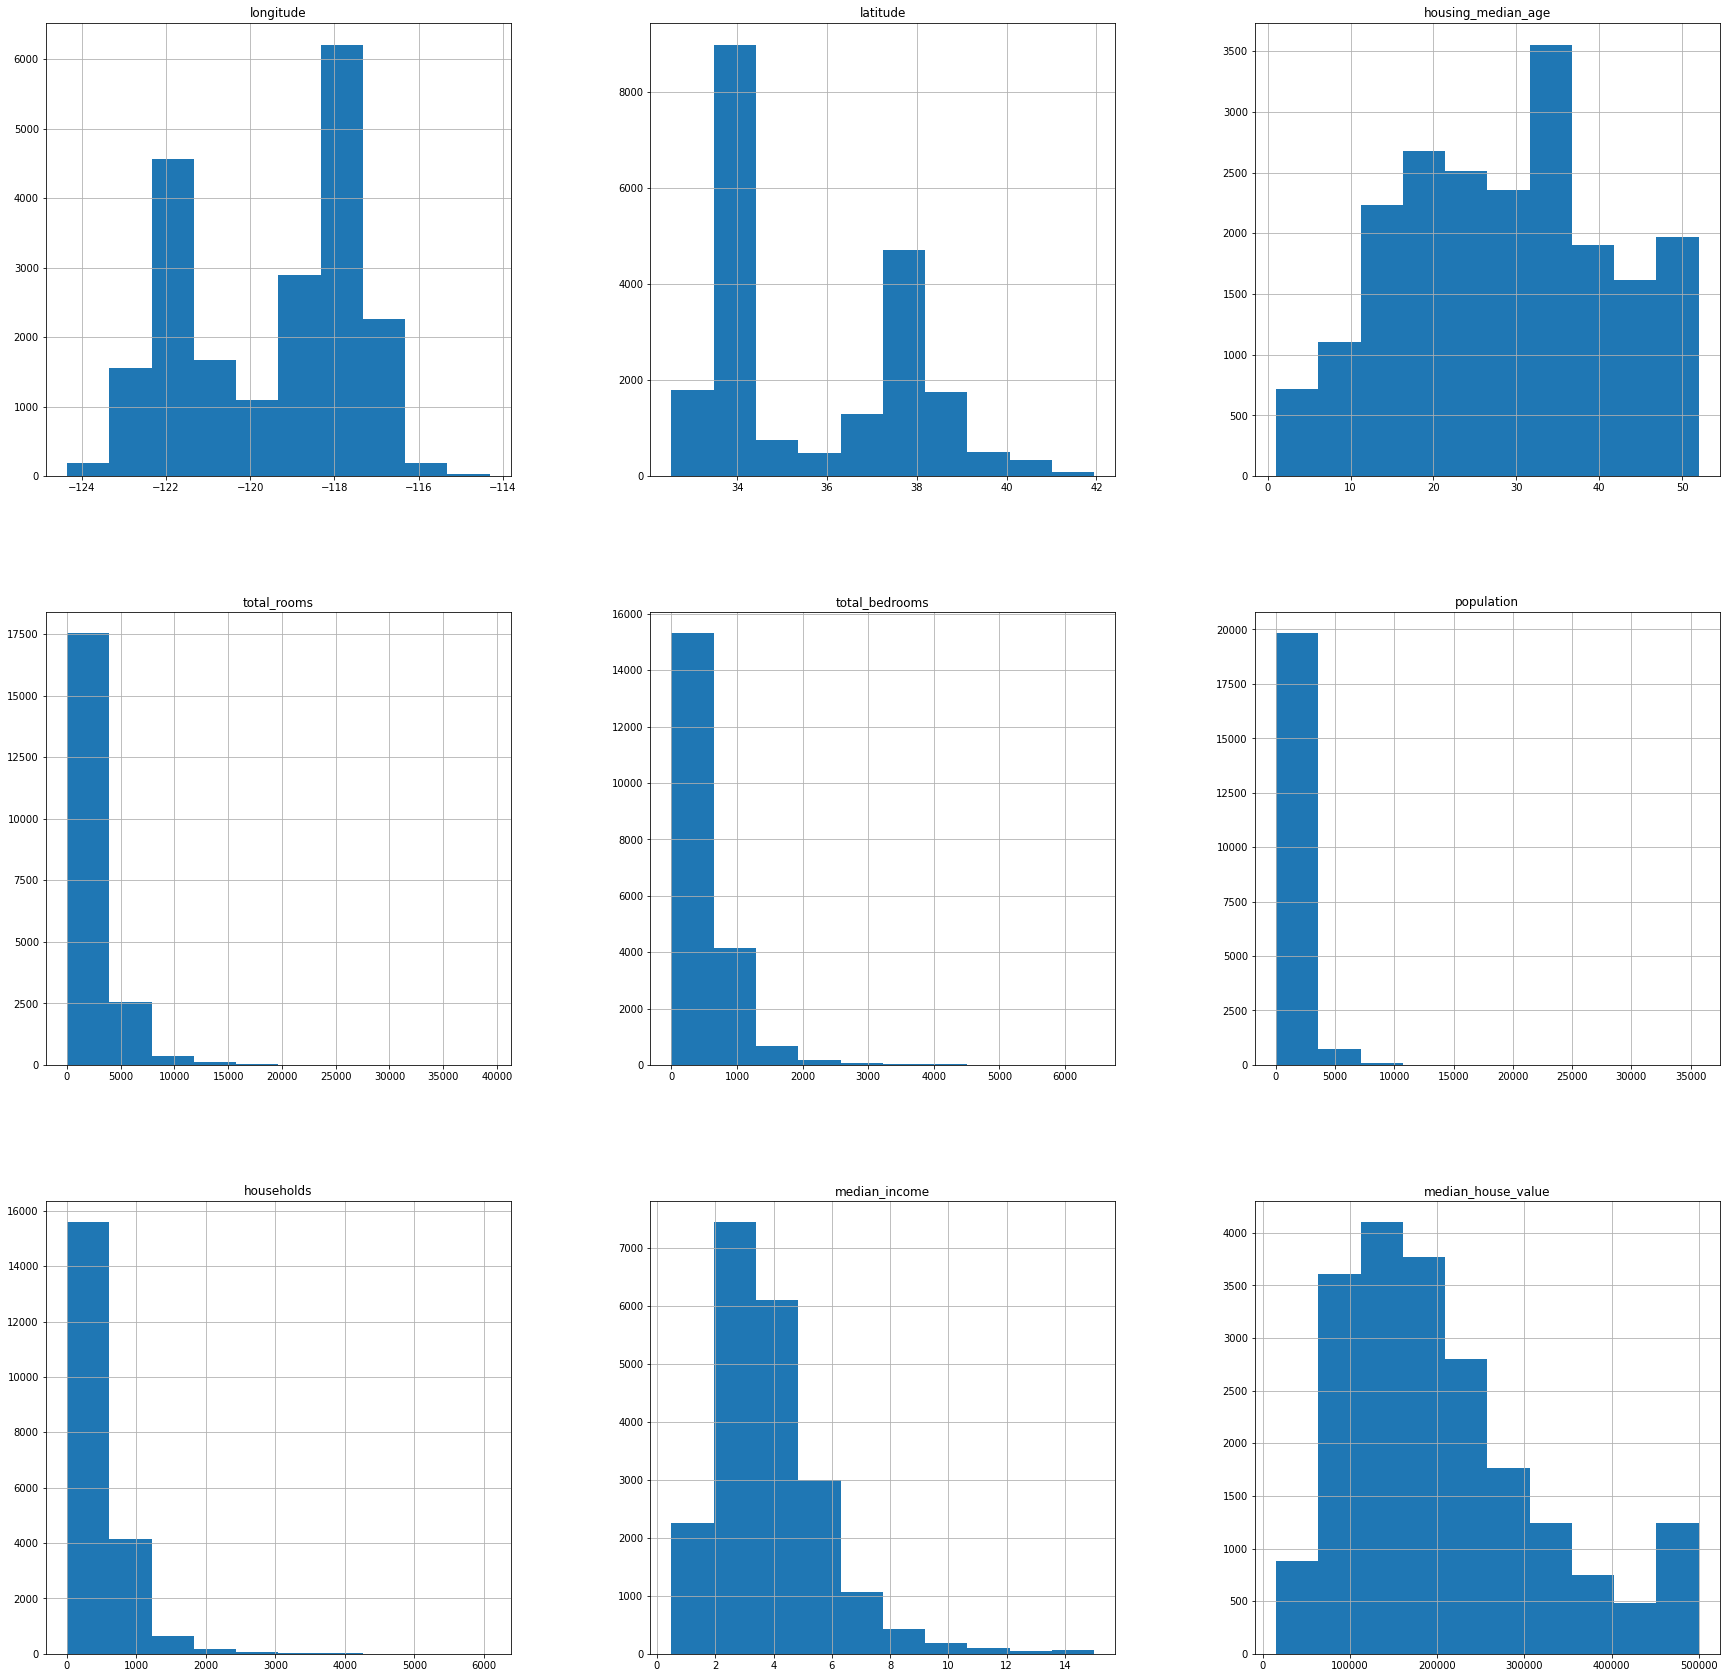

In [9]:
import matplotlib.pyplot as plt
data.hist(figsize=(30,30))

## Random index

In [10]:
import numpy as np
def split_train_test(data,test_ratio):
    suffle_index = np.random.permutation(len(data)) # return permutation in range
    test_size = int(len(data)*test_ratio)
    test_index = suffle_index[:test_size]
    train_index = suffle_index[test_size:]
    return data.iloc[train_index],data.iloc[test_index]
train_data, test_data = split_train_test(data,0.2)



## Cách này phù hợp với dữ liệu mới bằng cách thêm vào cuối danh sách

In [11]:
from zlib import crc32
import numpy as np
def test_check(index,test_ratio):
    return crc32(np.int64(index)) < test_ratio*2**32 #hash 
def split_train_test_by_id(data,test_ratio,columns):
    index = data[columns]
    index_test = index.apply(lambda idx:test_check(idx,test_ratio))
    return data.loc[~index_test],data.loc[index_test]
data_index = data.reset_index()
train, test = split_train_test_by_id(data_index,0.2,"index")
len(train)

16512

## Use Sklearn to separate data to train and test (Train_test_split)
* cut: chia dữ liệu thành từng loại


<AxesSubplot:>

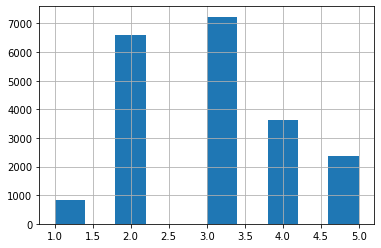

In [12]:
data['income_cat'] = pd.cut(data['median_income'],bins = [0.,1.5,3.0,4.5,6.,np.inf],labels = [1,2,3,4,5])
data['income_cat'].hist()

In [13]:
from sklearn.model_selection import train_test_split
train_set_split, test_set_split = train_test_split(data,test_size = 0.2,random_state=42)


## Use Sklearn to get 'Stratified Sampleling':

In [14]:
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits = 1,test_size= 0.2,random_state= 42)
for train_index, test_index in split.split(data,data['income_cat']):
    train_set_strat = data.loc[train_index]
    test_set_strat = data.loc[test_index]

## Compare 2 ways to sampling

In [15]:
def income_cat_propotion(data):
    return (data['income_cat'].value_counts()/len(data)).sort_index()

In [16]:
rand_set_split =income_cat_propotion(test_set_split)
rand_set_stratified = income_cat_propotion(test_set_strat)
original = income_cat_propotion(data)
compare_frame = pd.DataFrame({'Original':original,'Stratified':rand_set_stratified,'Random':rand_set_split})
compare_frame["Rand. %error"] = compare_frame['Random']*100 / compare_frame['Original'] - 100
compare_frame["Strat. %error"] = compare_frame['Stratified']*100 / compare_frame['Original'] - 100
compare_frame

,Original,Stratified,Random,Rand. %error,Strat. %error
1,0.039826,0.039729,0.040213,0.973236,-0.243309
2,0.318847,0.318798,0.324370,1.732260,-0.015195
3,0.350581,0.350533,0.358527,2.266446,-0.013820
4,0.176308,0.176357,0.167393,-5.056334,0.027480
5,0.114438,0.114583,0.109496,-4.318374,0.127011


### => Get data by Stratified because its close to Original data

In [17]:
for set_ in (train_set_strat,test_set_strat):
    set_.drop(columns = 'income_cat',inplace = True)
train_set_strat

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,286600.0,<1H OCEAN
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,340600.0,<1H OCEAN
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,196900.0,NEAR OCEAN
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,46300.0,INLAND
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,254500.0,<1H OCEAN
...,...,...,...,...,...,...,...,...,...,...
6563,-118.13,34.20,46.0,1271.0,236.0,573.0,210.0,4.9312,240200.0,INLAND
12053,-117.56,33.88,40.0,1196.0,294.0,1052.0,258.0,2.0682,113000.0,INLAND
13908,-116.40,34.09,9.0,4855.0,872.0,2098.0,765.0,3.2723,97800.0,INLAND
11159,-118.01,33.82,31.0,1960.0,380.0,1356.0,356.0,4.0625,225900.0,<1H OCEAN


## Visualization 
* c: Màu sắc đại diện
* s: bán kính vòng tròn
* alpha: mật độ bên trong vòng tròn

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

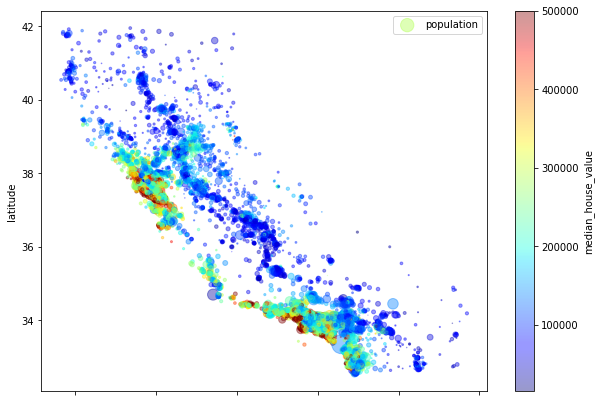

In [18]:
housing_copy = train_set_strat.copy()
housing_copy.plot(kind = 'scatter',x='longitude',y='latitude',figsize = (10,7),alpha = 0.4,
                c = 'median_house_value',cmap = plt.get_cmap('jet'),colorbar = True,label = 'population',s = housing_copy['population']/100)


## Correlation 

In [19]:
corr = housing_copy.corr()
corr['median_house_value'].sort_values(ascending = False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

array([[<AxesSubplot:xlabel='median_house_value', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='median_income', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='median_house_value'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='median_income'>,
        <AxesSubplot:xlabel='median_income', ylabel='median_income'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='median_income'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='median_income'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='median_income', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='total_rooms'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='housing_median_age'>,
        <AxesSubplot:xlabel='median_incom

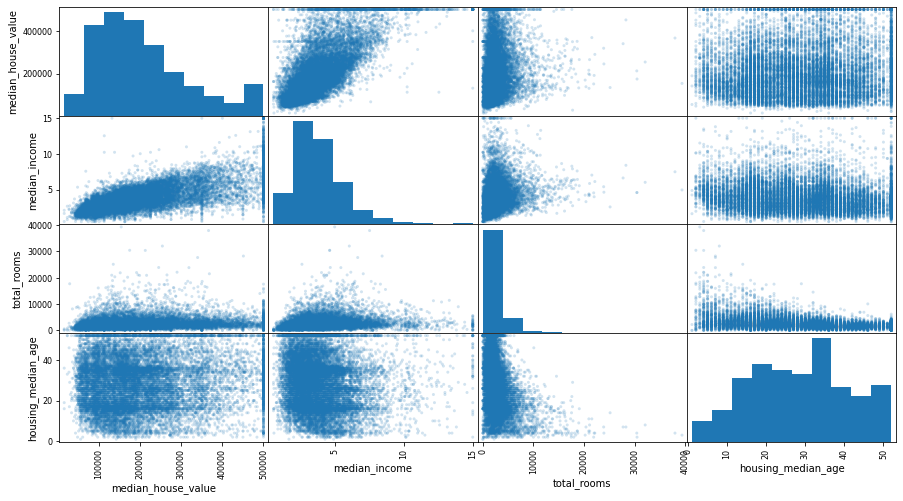

In [20]:
from pandas.plotting import scatter_matrix
attribute = ['median_house_value','median_income','total_rooms','housing_median_age']
scatter_matrix(housing_copy[attribute],figsize = (15,8),alpha = 0.2)

<AxesSubplot:xlabel='median_income', ylabel='median_house_value'>

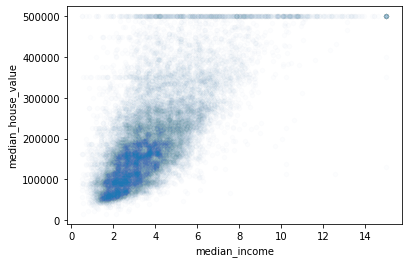

In [21]:
housing_copy.plot(x = 'median_income',y = 'median_house_value',kind = 'scatter',alpha = 0.01)


In [22]:
housing_copy['rooms_per_household'] = housing_copy['total_rooms'] / housing_copy['households']
housing_copy['bedrooms_per_room'] = housing_copy['total_bedrooms'] / housing_copy['total_rooms']
housing_copy['population_per_households'] = housing_copy['population'] / housing_copy['households']
corr_matrix = housing_copy.corr()
corr_matrix['median_house_value'].sort_values(ascending = False)

median_house_value           1.000000
median_income                0.687160
rooms_per_household          0.146285
total_rooms                  0.135097
housing_median_age           0.114110
households                   0.064506
total_bedrooms               0.047689
population_per_households   -0.021985
population                  -0.026920
longitude                   -0.047432
latitude                    -0.142724
bedrooms_per_room           -0.259984
Name: median_house_value, dtype: float64

# Prepare data
* Xử lí total_bedrooms

In [23]:
housing = train_set_strat.drop(columns = "median_house_value")
housing_label = train_set_strat['median_house_value'].copy()


## Xử lí giá trị thiếu bằng Sklearn.impute

In [24]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy= 'median')
housing_num = housing.drop(columns = 'ocean_proximity')
imputer.fit(housing_num)
housing_num.median().values == imputer.statistics_


array([ True,  True,  True,  True,  True,  True,  True,  True])

In [25]:
X = imputer.transform(housing_num)
housing_trans = pd.DataFrame(X,columns = housing_num.columns,index =housing_num.index)
housing_trans

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347
...,...,...,...,...,...,...,...,...
6563,-118.13,34.20,46.0,1271.0,236.0,573.0,210.0,4.9312
12053,-117.56,33.88,40.0,1196.0,294.0,1052.0,258.0,2.0682
13908,-116.40,34.09,9.0,4855.0,872.0,2098.0,765.0,3.2723
11159,-118.01,33.82,31.0,1960.0,380.0,1356.0,356.0,4.0625


## Xử lí thuộc tính văn bản bằng OrdinalEncoder(chuyển từng hạng mục sang số)

In [26]:
housing_ocean = housing[['ocean_proximity']]
housing_ocean.value_counts()

ocean_proximity
<1H OCEAN          7276
INLAND             5263
NEAR OCEAN         2124
NEAR BAY           1847
ISLAND                2
dtype: int64

In [27]:
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()
housing_ocean_encoder = ordinal_encoder.fit_transform(housing_ocean) # tương tự fit=>transform
housing_ocean_encoder

array([[0.],
       [0.],
       [4.],
       ...,
       [1.],
       [0.],
       [3.]])

In [28]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

## Xử lí thuộc tính văn bản bằng OneHotEncoder(chuyển sang ma trận thưa scipy)

In [29]:
from sklearn.preprocessing import OneHotEncoder
one_hot = OneHotEncoder()
housing_one_hot = one_hot.fit_transform(housing_ocean)
housing_one_hot.toarray() # ma trận thưa

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [30]:
one_hot.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

## Bộ biến đổi tùy chỉnh
* np.c_: chỉ dành cho array

In [31]:
from sklearn.base import BaseEstimator,TransformerMixin
rooms_ix, bedrooms_ix, population_ix, households_ix = 3,4,5,6 # Trục
class CombineAttribute(BaseEstimator,TransformerMixin):
    def __init__(self,add_bedroom_per_room= True): # No *args and **kargs
        self.add_bedroom_per_room = add_bedroom_per_room
    def fit(self,X,y= None):
        return self
    def transform(self,X):
        rooms_per_household = X[:,rooms_ix] / X[:,households_ix]
        population_per_household = X[:,population_ix] / X[:,households_ix]
        if self.add_bedroom_per_room :
            add_bedroom_per_room = X[:,bedrooms_ix] / X[:,rooms_ix]
            return np.c_[X,rooms_per_household,population_per_household,add_bedroom_per_room] # Nối các trục
        return np.c_[X,rooms_per_household,population_per_household]
add_atribute = CombineAttribute(add_bedroom_per_room= True)
housing_new = add_atribute.transform(housing.values)    


In [32]:
housing.values

array([[-121.89, 37.29, 38.0, ..., 339.0, 2.7042, '<1H OCEAN'],
       [-121.93, 37.05, 14.0, ..., 113.0, 6.4214, '<1H OCEAN'],
       [-117.2, 32.77, 31.0, ..., 462.0, 2.8621, 'NEAR OCEAN'],
       ...,
       [-116.4, 34.09, 9.0, ..., 765.0, 3.2723, 'INLAND'],
       [-118.01, 33.82, 31.0, ..., 356.0, 4.0625, '<1H OCEAN'],
       [-122.45, 37.77, 52.0, ..., 639.0, 3.575, 'NEAR BAY']],
      dtype=object)

# Co giãn đặc trưng
* Min-max scaling(chuẩn hóa: normalization)
* Chuẩn tắc hóa: standardization
## Ta chỉ khớp cho dữ liệu huấn luyện. Sau đó ta mới dùng dể biến đổi tập huấn luyện và kiếm tra

## Normalization

In [33]:
total_room = housing[['total_rooms']]
min_total_room = min(total_room.values)
max_total_room = max(total_room.values)

total_room = total_room.apply(lambda x: (x - min_total_room )/ (max_total_room - min_total_room))
total_room

,total_rooms
17606,0.039731
18632,0.017119
14650,0.049499
3230,0.046828
3555,0.167523
...,...
6563,0.032177
12053,0.030269
13908,0.123340
11159,0.049702


In [34]:
from sklearn.preprocessing import MinMaxScaler
min_max = MinMaxScaler(feature_range = [0,1])
total = min_max.fit_transform(total_room)
total

array([[0.03973139],
       [0.01711858],
       [0.04949891],
       ...,
       [0.12334029],
       [0.0497024 ],
       [0.07857252]])

## Standardization

In [35]:
standard_rooms = housing[['total_rooms']]
mean = np.mean(standard_rooms.values)
s = np.sqrt(np.var(standard_rooms.values))

In [36]:
standard_rooms_1 = standard_rooms.apply(lambda x: (x - mean) / s)
standard_rooms_1

,total_rooms
17606,-0.493234
18632,-0.908967
14650,-0.313660
3230,-0.362762
3555,1.856193
...,...
6563,-0.632123
12053,-0.667196
13908,1.043901
11159,-0.309919


In [37]:
from sklearn.preprocessing import StandardScaler
std_scaler = StandardScaler()
standard_rooms_scale = std_scaler.fit_transform(standard_rooms)
standard_rooms_scale

array([[-0.49323393],
       [-0.90896655],
       [-0.31365989],
       ...,
       [ 1.04390119],
       [-0.30991876],
       [ 0.22085348]])

# Pipeline

In [38]:
from sklearn.pipeline import Pipeline
pipeline = Pipeline([
    ('imputer',SimpleImputer(strategy= 'median')), 
    ('atribute_add',CombineAttribute()),
    ('std_scaler', StandardScaler())
])
housing_pipe = pipeline.fit_transform(housing_num)
housing_pipe

array([[-1.15604281,  0.77194962,  0.74333089, ..., -0.31205452,
        -0.08649871,  0.15531753],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.21768338,
        -0.03353391, -0.83628902],
       [ 1.18684903, -1.34218285,  0.18664186, ..., -0.46531516,
        -0.09240499,  0.4222004 ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.3469342 ,
        -0.03055414, -0.52177644],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.02499488,
         0.06150916, -0.30340741],
       [-1.43579109,  0.99645926,  1.85670895, ..., -0.22852947,
        -0.09586294,  0.10180567]])

## Column transformer

In [39]:
num_atribute = list(housing_num)
cat_atribute = ["ocean_proximity"]
 

In [40]:
from sklearn.compose import ColumnTransformer
full_pipeline = ColumnTransformer([
    ("num",pipeline,num_atribute), # tên, bộ biến đổi, tên cột
    ("cat",OneHotEncoder(),cat_atribute)
])
housing_prepared = full_pipeline.fit_transform(housing) # return in num_atribute and ocean_
housing_prepared[0]

array([-1.15604281,  0.77194962,  0.74333089, -0.49323393, -0.44543821,
       -0.63621141, -0.42069842, -0.61493744, -0.31205452, -0.08649871,
        0.15531753,  1.        ,  0.        ,  0.        ,  0.        ,
        0.        ])

# Huấn luyện mô hình hồi quy

In [53]:
from sklearn.linear_model import LinearRegression
lig_reg = LinearRegression()
lig_reg.fit(housing_prepared,housing_label)

LinearRegression()

In [42]:
some_data = housing.iloc[:5]
some_label = housing_label.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
print("Predictions: ", lig_reg.predict(some_data_prepared))
print("Labels: ", list(some_label))

Predictions:  [210644.60459286 317768.80697211 210956.43331178  59218.98886849
 189747.55849879]
Labels:  [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


## Ta có thể thấy dự đoán bị lệch trung bình là 68628

In [43]:
from sklearn.metrics import mean_squared_error
housing_prediction = lig_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_label,housing_prediction)
lin_mse = np.sqrt(lin_mse)
lin_mse

68628.19819848922

# Sử dụng DecisionTree để dự đoán

In [44]:
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor(random_state= 42)
tree_reg.fit(housing_prepared,housing_label)

DecisionTreeRegressor(random_state=42)

In [45]:
housing_tree_predict = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_label,housing_tree_predict)
np.sqrt(tree_mse)

0.0

# Kiếm định chéo K-fold( K-fold cross-validation): 
* Chia ngẫu nhiên tập huấn luyện thành n(_cv) tập con riêng biệt gọi là fold
* Rồi huấn luyện và đánh giá mô hình n lần, mỗi lần chọn 1 fold khác nhau để đánh giá và huấn luyện n-1 fold còn lại
* Kết quả trả về là 1 mảng chứa n điểm số đánh giá
# Lưu ý:
* Tính năng kiểm định chéo làm việc với **hàm lợi ích( càng cao càng tốt)** thay vì **hàm chi phí( càng thấp càng tốt)**, nên hàm tính điểm là hàm đối của **MSE( tức có giá trị âm)**

## Kiểm định chéo trên mô hình DecisionTree

In [46]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(tree_reg,housing_prepared,housing_label,scoring='neg_mean_squared_error',cv = 10)
tree_rmse_scores = np.sqrt(-scores)
tree_rmse_scores

KeyboardInterrupt: 

In [ ]:
def display(scores):
    print("Scores:",scores)
    print("Mean:",scores.mean())
    print("Standard Deviation:",scores.std())

In [ ]:
display(tree_rmse_scores)

Scores: [70194.33680785 66855.16363941 72432.58244769 70758.73896782
 71115.88230639 75585.14172901 70262.86139133 70273.6325285
 75366.87952553 71231.65726027]
Mean: 71407.68766037929
Standard Deviation: 2439.4345041191004


## => Mô hình DecisionTree có điểm số khoảng $$71407 \pm 2439 $$

## Kiểm định chéo trên mô hình Linear


In [54]:
score_linear = cross_val_score(lig_reg,housing_prepared,housing_label,scoring= "neg_mean_squared_error",cv = 10)
lin_rmse_scores = np.sqrt(-score_linear)
display(lin_rmse_scores)

array([66782.73843989, 66960.118071  , 70347.95244419, 74739.57052552,
       68031.13388938, 71193.84183426, 64969.63056405, 68281.61137997,
       71552.91566558, 67665.10082067])

## Mô hình có điểm số khoảng: $$69052\pm2731$$

## Kiểm định chéo trên mô hình RandomForest

In [ ]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor(n_estimators= 100,random_state= 42)
forest_reg.fit(housing_prepared,housing_label)

KeyboardInterrupt: 

In [ ]:
forest_predict = forest_reg.predict(housing_prepared)
forest_rmse = mean_squared_error(housing_label,forest_predict)
forest_rmse = np.sqrt(forest_rmse)
forest_rmse

18603.515021376355

In [ ]:
score_forest = cross_val_score(forest_reg,housing_prepared,housing_label,scoring = 'neg_mean_squared_error',cv = 10)
score_forest_rmse = np.sqrt(-score_forest)
display(score_forest_rmse)

KeyboardInterrupt: 

## => Mô hình có điểm số khoảng: $$50182\pm2097$$

# Lưu mô hình

In [ ]:
import joblib 
joblib.dump(lig_reg,"linear.pkl")

['linear.pkl']

In [ ]:
model = joblib.load("linear.pkl")
model

LinearRegression()

# Tinh chỉnh mô hình

## Tìm kiếm dạng lưới

In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid = [
    {'n_estimators':[3,10,30],'max_features':[2,4,6,8]},
    {'bootstrap':[False],'n_estimators':[3,10],'max_features':[2,3,4]}
]
forest_reg = RandomForestRegressor(random_state = 42)
grid_search = GridSearchCV(forest_reg,param_grid= param_grid,cv = 5,scoring="neg_mean_squared_error",return_train_score=True)
grid_search.fit(housing_prepared,housing_label)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [ ]:
grid_search_model = joblib.dump(grid_search,"grid_search.pkl")

In [ ]:
grid_search = joblib.load("grid_search.pkl")

In [ ]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

In [ ]:
grid_search.best_estimator_

RandomForestRegressor(max_features=8, n_estimators=30, random_state=42)

In [ ]:
all_case_score = grid_search.cv_results_
mean_test_score = np.sqrt(-all_case_score['mean_test_score'])
params = all_case_score['params']
choose = pd.DataFrame(mean_test_score).join(pd.DataFrame(params))  
choose = choose.rename(columns = {0:'mean_test_score'})
choose = choose.fillna('True')

In [ ]:
choose.sort_values(by = 'mean_test_score')

,mean_test_score,max_features,n_estimators,bootstrap
11,49682.273345,8,30,True
8,50146.511674,6,30,True
5,50377.404617,4,30,True
17,51009.495669,4,10,False
10,51711.127884,8,10,True
7,52006.198735,6,10,True
15,52724.982259,3,10,False
4,52741.047043,4,10,True
2,53384.572751,2,30,True
13,54658.176158,2,10,False


## =>  max_features = 8, n_estimators = 30 là tốt nhất

## Tìm kiếm ngẫu nhiên

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
random_search = RandomizedSearchCV(forest_reg,param_distributions = param_grid,scoring = 'neg_mean_squared_error',cv = 5)
random_search.fit(housing_prepared,housing_label)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   param_distributions=[{'max_features': [2, 4, 6, 8],
                                         'n_estimators': [3, 10, 30]},
                                        {'bootstrap': [False],
                                         'max_features': [2, 3, 4],
                                         'n_estimators': [3, 10]}],
                   scoring='neg_mean_squared_error')

# Phương pháp Ensemble

## Phân tích các mô hình tốt nhất và lỗi của chúng

In [ ]:
feature_important = grid_search.best_estimator_.feature_importances_
feature_important

array([7.33442355e-02, 6.29090705e-02, 4.11437985e-02, 1.46726854e-02,
       1.41064835e-02, 1.48742809e-02, 1.42575993e-02, 3.66158981e-01,
       5.64191792e-02, 1.08792957e-01, 5.33510773e-02, 1.03114883e-02,
       1.64780994e-01, 6.02803867e-05, 1.96041560e-03, 2.85647464e-03])

In [ ]:
extra_attribute = ['room_per_hhold','pop_per_hhold','bedroom_per_room']
cat_encoder = full_pipeline.named_transformers_['cat']
cat_one_hot_attribute = list(cat_encoder.categories_[0])
attributes = num_atribute +extra_attribute + cat_one_hot_attribute
sorted(zip(feature_important,attributes),reverse= True)

[(0.36615898061813423, 'median_income'),
 (0.16478099356159054, 'INLAND'),
 (0.10879295677551575, 'pop_per_hhold'),
 (0.07334423551601243, 'longitude'),
 (0.06290907048262032, 'latitude'),
 (0.056419179181954014, 'room_per_hhold'),
 (0.053351077347675815, 'bedroom_per_room'),
 (0.04114379847872964, 'housing_median_age'),
 (0.014874280890402769, 'population'),
 (0.014672685420543239, 'total_rooms'),
 (0.014257599323407808, 'households'),
 (0.014106483453584104, 'total_bedrooms'),
 (0.010311488326303788, '<1H OCEAN'),
 (0.0028564746373201584, 'NEAR OCEAN'),
 (0.0019604155994780706, 'NEAR BAY'),
 (6.0280386727366e-05, 'ISLAND')]

## => Với các thông tin trên, có thể loại bỏ các đặc trưng ít hữu dụng

## Đánh giá hệ thống trên tập kiểm tra

In [ ]:
final_model = grid_search.best_estimator_
X_test = test_set_strat.drop("median_house_value", axis=1)
Y_test = test_set_strat['median_house_value']
X_test_prepared = full_pipeline.transform(X_test)
final_predict = final_model.predict(X_test_prepared)
final_mse = mean_squared_error(Y_test,final_predict)
final_rmse = np.sqrt(final_mse)

In [ ]:
final_rmse

47730.22690385927

### Tính toán mức độ chính xác với khoảng tin cậy 95%

* loc: mean
* scale : sai số so với mean

In [ ]:
from scipy import stats
confidence = 0.95 
square_error = (final_predict - Y_test)**2
np.sqrt(stats.t.interval(confidence,len(square_error) - 1,loc = square_error.mean(),scale = stats.sem(square_error)))


array([45685.10470776, 49691.25001878])

# Bài tập

## Bài 1:

In [ ]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
svr = SVR()
param_grid = [
    {'kernel': ['linear'], "C" : [10,30,100,300,1000,3000,10000,30000]},
    {'kernel': ['rbf'], 'C': [1,3,10,30,100,300,1000],'gamma': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0]}
]
grid_search_svr = GridSearchCV(svr,param_grid,scoring = 'neg_mean_squared_error',cv = 5,verbose= 2)
grid_search_svr.fit(housing_prepared,housing_label)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END ................................C=10, kernel=linear; total time=   5.8s
[CV] END ................................C=10, kernel=linear; total time=   5.8s
[CV] END ................................C=10, kernel=linear; total time=   6.1s
[CV] END ................................C=10, kernel=linear; total time=   6.1s
[CV] END ................................C=10, kernel=linear; total time=   5.9s
[CV] END ................................C=30, kernel=linear; total time=   5.9s
[CV] END ................................C=30, kernel=linear; total time=   5.7s
[CV] END ................................C=30, kernel=linear; total time=   5.8s
[CV] END ................................C=30, kernel=linear; total time=   5.7s
[CV] END ................................C=30, kernel=linear; total time=   5.8s
[CV] END ...............................C=100, kernel=linear; total time=   5.8s
[CV] END ...............................C=100, 

GridSearchCV(cv=5, estimator=SVR(),
             param_grid=[{'C': [10, 30, 100, 300, 1000, 3000, 10000, 30000],
                          'kernel': ['linear']},
                         {'C': [1, 3, 10, 30, 100, 300, 1000],
                          'gamma': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0],
                          'kernel': ['rbf']}],
             scoring='neg_mean_squared_error', verbose=2)

In [ ]:
grid_search_svr_model = joblib.dump(grid_search_svr,"grid_search_svr.pkl")

In [ ]:
grid_search_svr_model = joblib.load("grid_search_svr.pkl")


In [ ]:
svr_rmse = np.sqrt(-grid_search_svr_model.best_score_)
svr_rmse

70363.84006006805

In [ ]:
grid_search_svr_model.best_params_

{'C': 30000, 'kernel': 'linear'}

## Bài 2:

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVR
from scipy.stats import expon, reciprocal

svr_reg = SVR() 

param_distribution ={
        'kernel':['linear','rbf'],
        'C' : reciprocal(20,200000),
        'gamma':expon(scale = 1.0)
    }
random_search_cv = RandomizedSearchCV(svr_reg,param_distributions = param_distribution,
                                        scoring = 'neg_mean_squared_error', 
                                        cv = 5,verbose = 2,n_iter= 50,random_state = 42)
random_search_cv.fit(housing_prepared,housing_label)


Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END C=629.782329591372, gamma=3.010121430917521, kernel=linear; total time=   5.9s
[CV] END C=629.782329591372, gamma=3.010121430917521, kernel=linear; total time=   5.9s
[CV] END C=629.782329591372, gamma=3.010121430917521, kernel=linear; total time=   5.9s
[CV] END C=629.782329591372, gamma=3.010121430917521, kernel=linear; total time=   6.0s
[CV] END C=629.782329591372, gamma=3.010121430917521, kernel=linear; total time=   6.3s
[CV] END C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf; total time=  14.3s
[CV] END C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf; total time=  14.9s
[CV] END C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf; total time=  14.2s
[CV] END C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf; total time=  14.5s
[CV] END C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf; total time=  14.7s
[CV] END C=84.14107900575871, gamma=0.059838768608680676, 

RandomizedSearchCV(cv=5, estimator=SVR(), n_iter=50,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001B0DB9B0310>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001B0E46D5C10>,
                                        'kernel': ['linear', 'rbf']},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=2)

In [ ]:
joblib.dump(random_search_cv,"random_search_cv.pkl")

['random_search_cv.pkl']

In [ ]:
random_cv = joblib.load("random_search_cv.pkl")
random_cv

RandomizedSearchCV(cv=5, estimator=SVR(), n_iter=50,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000205A6877430>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000205A69DCA30>,
                                        'kernel': ['linear', 'rbf']},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=2)

In [ ]:
score = np.sqrt(-random_cv.best_score_)
best_param = random_cv.best_params_
best_param,print("score: ",score)

score:  54767.960710084124


({'C': 157055.10989448498, 'gamma': 0.26497040005002437, 'kernel': 'rbf'},
 None)

Hàm exp

(array([  1.,   0.,   0.,   1.,   0.,   1.,   0.,   0.,   0.,   1.,   0.,
          4.,   0.,   2.,   2.,   2.,   3.,   4.,   1.,   2.,   4.,   6.,
         13.,  16.,  26.,  36.,  35.,  52.,  66.,  78., 115., 155., 212.,
        234., 319., 375., 460., 595., 679., 827., 927., 976., 989., 854.,
        788., 532., 375., 157.,  61.,  14.]),
 array([-11.36150797, -11.09226245, -10.82301692, -10.5537714 ,
        -10.28452588, -10.01528035,  -9.74603483,  -9.47678931,
         -9.20754378,  -8.93829826,  -8.66905274,  -8.39980721,
         -8.13056169,  -7.86131616,  -7.59207064,  -7.32282512,
         -7.05357959,  -6.78433407,  -6.51508855,  -6.24584302,
         -5.9765975 ,  -5.70735198,  -5.43810645,  -5.16886093,
         -4.89961541,  -4.63036988,  -4.36112436,  -4.09187884,
         -3.82263331,  -3.55338779,  -3.28414227,  -3.01489674,
         -2.74565122,  -2.4764057 ,  -2.20716017,  -1.93791465,
         -1.66866913,  -1.3994236 ,  -1.13017808,  -0.86093256,
         -0.591687

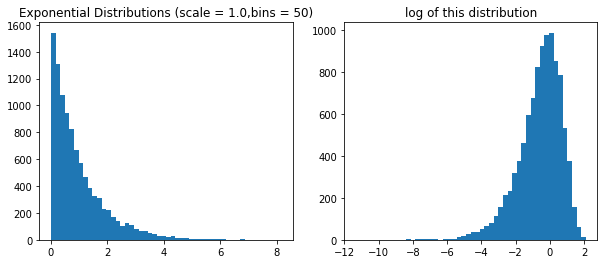

In [ ]:
expon_distribution = expon(scale = 1.0)
samples = expon_distribution.rvs(10000,random_state= 42) #random variates
plt.figure(figsize = (10,4))
plt.subplot(1,2,1) # row, col, index
plt.title("Exponential Distributions (scale = 1.0,bins = 50)")
plt.hist(samples,bins = 50)
plt.subplot(1,2,2)
plt.title("log of this distribution")
plt.hist(np.log(samples),bins = 50)

(array([197., 201., 209., 223., 201., 200., 214., 181., 213., 204., 196.,
        195., 222., 198., 197., 194., 204., 210., 190., 208., 228., 193.,
        211., 173., 213., 235., 179., 210., 201., 208., 195., 193., 201.,
        221., 195., 189., 197., 173., 184., 179., 226., 197., 186., 209.,
        184., 174., 198., 210., 200., 181.]),
 array([ 2.99583943,  3.17999209,  3.36414475,  3.54829741,  3.73245006,
         3.91660272,  4.10075538,  4.28490804,  4.4690607 ,  4.65321335,
         4.83736601,  5.02151867,  5.20567133,  5.38982398,  5.57397664,
         5.7581293 ,  5.94228196,  6.12643462,  6.31058727,  6.49473993,
         6.67889259,  6.86304525,  7.0471979 ,  7.23135056,  7.41550322,
         7.59965588,  7.78380853,  7.96796119,  8.15211385,  8.33626651,
         8.52041917,  8.70457182,  8.88872448,  9.07287714,  9.2570298 ,
         9.44118245,  9.62533511,  9.80948777,  9.99364043, 10.17779309,
        10.36194574, 10.5460984 , 10.73025106, 10.91440372, 11.09855637,
 

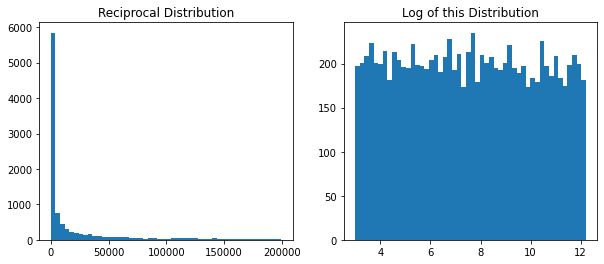

In [ ]:
reciprocal_distribution = reciprocal(20,200000)
samples = reciprocal_distribution.rvs(10000,random_state = 42)
plt.figure(figsize = (10,4))
plt.subplot(1,2,1) 
plt.title("Reciprocal Distribution")
plt.hist(samples,bins = 50)
plt.subplot(1,2,2)
plt.title("Log of this Distribution")
plt.hist(np.log(samples),bins = 50)

# Bài 3:

In [ ]:
sorted(zip(feature_important,attributes),key = lambda x:x[0],reverse = True)

[(0.36615898061813423, 'median_income'),
 (0.16478099356159054, 'INLAND'),
 (0.10879295677551575, 'pop_per_hhold'),
 (0.07334423551601243, 'longitude'),
 (0.06290907048262032, 'latitude'),
 (0.056419179181954014, 'room_per_hhold'),
 (0.053351077347675815, 'bedroom_per_room'),
 (0.04114379847872964, 'housing_median_age'),
 (0.014874280890402769, 'population'),
 (0.014672685420543239, 'total_rooms'),
 (0.014257599323407808, 'households'),
 (0.014106483453584104, 'total_bedrooms'),
 (0.010311488326303788, '<1H OCEAN'),
 (0.0028564746373201584, 'NEAR OCEAN'),
 (0.0019604155994780706, 'NEAR BAY'),
 (6.0280386727366e-05, 'ISLAND')]

Chọn ra k đặc trưng tốt 


In [ ]:
def indicate_top_of_k(feature_important,k):
    return sorted(np.argpartition(feature_important,-k)[-k:])

In [ ]:
from sklearn.base import BaseEstimator,TransformerMixin
class Top_Feature_Important(BaseEstimator,TransformerMixin):
    def __init__(self,feature_important,k):
        self.feature_important = feature_important
        self.k = k
    def fit(self,X,y = None):
        self.indicate_feature = indicate_top_of_k(self.feature_important,self.k)
        return self
    def transform(self,X):
        return X[:,self.indicate_feature]

In [ ]:
k = 5

In [ ]:
a = np.array(attributes)[indicate_top_of_k(feature_important,k)]

array(['longitude', 'latitude', 'median_income', 'pop_per_hhold',
       'INLAND'], dtype='<U18')

In [ ]:
pipeline_top_feature = Pipeline([
    ("preparation",full_pipeline),
    ("top_feature",Top_Feature_Important(feature_important,k))
]
)

In [ ]:
housing_prepared_top_feature = pipeline_top_feature.fit_transform(housing)
housing_prepared_top_feature

array([[-1.15604281,  0.77194962, -0.61493744, -0.08649871,  0.        ],
       [-1.17602483,  0.6596948 ,  1.33645936, -0.03353391,  0.        ],
       [ 1.18684903, -1.34218285, -0.5320456 , -0.09240499,  0.        ],
       ...,
       [ 1.58648943, -0.72478134, -0.3167053 , -0.03055414,  1.        ],
       [ 0.78221312, -0.85106801,  0.09812139,  0.06150916,  0.        ],
       [-1.43579109,  0.99645926, -0.15779865, -0.09586294,  0.        ]])

In [ ]:
housing_prepared_top_feature[:3]

array([[-1.15604281,  0.77194962, -0.61493744, -0.08649871,  0.        ],
       [-1.17602483,  0.6596948 ,  1.33645936, -0.03353391,  0.        ],
       [ 1.18684903, -1.34218285, -0.5320456 , -0.09240499,  0.        ]])

In [ ]:
housing_prepared[:3,indicate_top_of_k(feature_important,5)]

array([[-1.15604281,  0.77194962, -0.61493744, -0.08649871,  0.        ],
       [-1.17602483,  0.6596948 ,  1.33645936, -0.03353391,  0.        ],
       [ 1.18684903, -1.34218285, -0.5320456 , -0.09240499,  0.        ]])

# Bài 4:

In [ ]:
housing_num = housing.drop(columns = 'ocean_proximity')
housing_cate = housing['ocean_proximity']

In [ ]:
num_pipeline = Pipeline([
    ("imputer",SimpleImputer(strategy= 'median')),
    ("combine_attribute",CombineAttribute()),
    ("std_scale",StandardScaler())
])
num_pipeline.fit_transform(housing_num)

array([[-1.15604281,  0.77194962,  0.74333089, ..., -0.31205452,
        -0.08649871,  0.15531753],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.21768338,
        -0.03353391, -0.83628902],
       [ 1.18684903, -1.34218285,  0.18664186, ..., -0.46531516,
        -0.09240499,  0.4222004 ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.3469342 ,
        -0.03055414, -0.52177644],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.02499488,
         0.06150916, -0.30340741],
       [-1.43579109,  0.99645926,  1.85670895, ..., -0.22852947,
        -0.09586294,  0.10180567]])

In [ ]:
num_attribute = list(housing_num)
cate_attribute = ['ocean_proximity']

In [ ]:
transform_columns_pipeline = ColumnTransformer([
    ('num',num_pipeline,num_attribute),
    ('categories',OneHotEncoder(),cate_attribute)
])

In [ ]:
random_search_cv = joblib.load("random_search_cv.pkl")

In [ ]:
full_pipeline = Pipeline([
    ("prepared_data",transform_columns_pipeline),
    ("top_feature",Top_Feature_Important(feature_important,k)),
    ("svm_reg",SVR(**random_search_cv.best_params_))
])
full_pipeline.fit(housing,housing_label)

Pipeline(steps=[('prepared_data',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('combine_attribute',
                                                                   CombineAttribute()),
                                                                  ('std_scale',
                                                                   StandardScaler())]),
                                                  ['longitude', 'latitude',
                                                   'housing_median_age',
                                                   'total_rooms',
                                                   'total_bedrooms',
                                                   'population', 'households',
                      

In [ ]:
some_data = housing.iloc[:4]
some_labels = housing_label.iloc[:4]
print("Predict: " ,full_pipeline.predict(some_data))
print("Label: ",list(some_labels))

Predict:  [203214.28978849 371846.88152572 173295.65441612  47328.3970888 ]
Label:  [286600.0, 340600.0, 196900.0, 46300.0]


# Bài 5:

In [ ]:
param_grid = [{
    'prepared_data__num__imputer__strategy': ['mean', 'median', 'most_frequent'],
    'top_feature__k': list(range(1, len(feature_important) + 1))
}]

grid_search_prep = GridSearchCV(full_pipeline, param_grid, cv=5,
                                scoring='neg_mean_squared_error', verbose=2)
grid_search_prep.fit(housing, housing_label)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] END prepared_data__num__imputer__strategy=mean, top_feature__k=1; total time=  10.0s
[CV] END prepared_data__num__imputer__strategy=mean, top_feature__k=1; total time=  10.0s
[CV] END prepared_data__num__imputer__strategy=mean, top_feature__k=1; total time=  10.0s
[CV] END prepared_data__num__imputer__strategy=mean, top_feature__k=1; total time=  10.2s
[CV] END prepared_data__num__imputer__strategy=mean, top_feature__k=1; total time=  10.2s
[CV] END prepared_data__num__imputer__strategy=mean, top_feature__k=2; total time=  10.2s
[CV] END prepared_data__num__imputer__strategy=mean, top_feature__k=2; total time=  10.6s
[CV] END prepared_data__num__imputer__strategy=mean, top_feature__k=2; total time=  11.0s
[CV] END prepared_data__num__imputer__strategy=mean, top_feature__k=2; total time=  19.4s
[CV] END prepared_data__num__imputer__strategy=mean, top_feature__k=2; total time=  12.4s
[CV] END prepared_data__num__imputer__

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('prepared_data',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('combine_attribute',
                                                                                          CombineAttribute()),
                                                                                         ('std_scale',
                                                                                          StandardScaler())]),
                                                                         ['longitude',
                                                                          'latitude',
         

In [ ]:
joblib.dump(grid_search_prep,"best_paramater")

['best_paramater']

In [ ]:
grid_search_prep.best_params_

{'prepared_data__num__imputer__strategy': 'most_frequent',
 'top_feature__k': 15}